In [1]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optimizers
from scipy.stats import norm
from numpy.random import *
from scipy import optimize

#np.random.seed(9837)
#torch.manual_seed(9837)

In [2]:
# 多項分布の乱数を生成する関数
def rmnom(pr, n, k, pattern):
    if pattern==1:
        z_id = np.array(np.argmax(np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis], axis=1), dtype="int")
        Z = np.diag(np.repeat(1, k))[z_id, ]
        return z_id, Z
    z_id = np.array(np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1), dtype="int")
    return z_id

# 切断ポアソン分布を生成する関数
def rtpois(mu, a, b, n, flag=0):
    FA = scipy.stats.poisson.cdf(a, mu)
    FB = scipy.stats.poisson.cdf(b, mu)
    x = np.array(scipy.stats.poisson.ppf(np.random.uniform(0, 1, n)*(FB-FA)+FA, mu), dtype="int")
    if flag==1:
        x = torch.Tensor(x)
    return x

def rtnorm(mu, sigma, a, b, n, flag=1):
    FA = norm.cdf(a, mu, sigma)
    FB = norm.cdf(b, mu, sigma)
    if flag==1:
        y = torch.Tensor(norm.ppf(np.random.uniform(0, 1, n)*(FB-FA)+FA, mu, sigma))
    else:
        y = norm.ppf(np.random.uniform(0, 1, n)*(FB-FA)+FA, mu, sigma)
    return y

# 入力データの定義

In [3]:
# データの生成
# データの定義
modes = 3   #モード数
r = 4   # ノイズ語のトピック数
k1 = 10; k2 = 5
d1 = 3000; d2 = 3000
seg1 = 800; seg2 = 400; seg3 = 400 
w1 = 2000; w2 = 500
k = k1 + k2
d = d1 + d2
seg = seg1 + seg2 + seg3 
w = w1 + w2

# レコード数を定義
k_vec = np.repeat(1.0, k)
max_seg = 5
m1 = rtpois(2.5, 0, max_seg, d1)
m2 = rtpois(2.5, 0, max_seg, d2)
Lambda1 = np.random.gamma(40.0, 1/0.2, w)
Lambda2 = np.random.gamma(60.0, 1/0.25, d1)
Lambda3 = np.random.gamma(60.0, 1/0.2, d2)
f1 = np.random.poisson(Lambda1, w)
pt1 = np.random.poisson(Lambda2, d1)
pt2 = np.random.poisson(Lambda3, d2)
F = np.sum(f1)
N1 = np.sum(pt1)
N2 = np.sum(pt2)

In [4]:
# 単語の割当インデックス
index_w1 = np.arange(w1)
index_w2 = np.arange(w1, w)
type_id = np.repeat(0, w)
type_id[index_w2] = 1

In [5]:
# IDとインデックスを作成
# IDの定義
wd1 = np.repeat(np.arange(w), f1)
d_id1 = np.repeat(np.arange(d1), pt1)
d_id2 = np.repeat(np.arange(d2), pt2)

# インデックスの定義
w_list1 = [i for i in range(w)]
d_list1 = [i for i in range(d1)]
d_list2 = [i for i in range(d2)] 
for i in range(w):
    w_list1[i] = np.array(np.where(wd1==i)[0], dtype="int")
for i in range(d1):
    d_list1[i] = np.array(np.where(d_id1==i)[0], dtype="int")
for i in range(d2):
    d_list2[i] = np.array(np.where(d_id2==i)[0], dtype="int")

In [6]:
# 共起wordの生成
# 多項分布からtopicを生成
topic = 30
theta_topic = np.random.dirichlet(np.repeat(0.2, topic), w)
phi_word = np.random.dirichlet(np.repeat(0.2, w), topic)
z = rmnom(theta_topic[wd1, ], F, topic, 0)

# トピックからwordを生成
# データの生成
wd2 = np.repeat(0, F)
for i in range(w):
    index = w_list1[i]
    words = rmnom(phi_word[z[index], ], f1[i], w, 0)
    if np.sum(words==i)==0:
        wd2[index] = words
        next
    while True:
        index_dup = np.where(words==i)[0]
        words[index_dup] = rmnom(phi_word[z[index][index_dup], ], index_dup.shape[0], w, 0)
        if np.sum(words==i)==0:
            wd2[index] = words
            break

# インデックスの定義
w_list2 = [i for i in range(w)]
f2 = np.repeat(0, w)
for i in range(w):
    w_list2[i] = np.array(np.where(wd2==i)[0], dtype="int")
    f2[i] = w_list2[i].shape[0]

In [7]:
# 文書segmentの生成
# パラメータを定義
theta_topic1 = np.random.dirichlet(np.repeat(0.2, topic), d1)
theta_topic2 = np.random.dirichlet(np.repeat(0.2, topic), d2)
phi_segment1 = np.zeros((topic, seg)); phi_segment2 = np.zeros((topic, seg))
phi_segment1[:, np.arange(seg1+seg2)] = np.random.dirichlet(np.repeat(0.5, seg1+seg2), topic)
phi_segment2[:, np.append(np.arange(seg1), np.arange(seg1+seg2, seg))] = np.random.dirichlet(np.repeat(0.5, seg1+seg3), topic)

# 多項分布からtopicとsegmentを生成
# データの格納用配列
z1 = np.full((d1, max_seg), topic)
seg_dt1 = np.full((d1, max_seg), seg+r)

for i in range(d1):
    # topicを生成
    while True:
        z_vec = np.argmax(np.random.multinomial(1, theta_topic1[i, ], m1[i]), axis=1)
        if m1[i]==np.unique(z_vec).shape[0]:
            break
    z1[i, np.arange(m1[i])] = z_vec

    # segmentを生成
    while True:
        if m1[i] > 1:
            seg_vec = rmnom(phi_segment1[z_vec, ], m1[i], seg, 0)
        else:
            seg_vec = np.argmax(np.random.multinomial(1, phi_segment1[z_vec, ].reshape(-1), m1[i]))
        if m1[i]==np.unique(seg_vec).shape[0]:
            break
    seg_dt1[i, np.arange(m1[i])] = seg_vec
     
# データの格納用配列    
z2 = np.full((d2, max_seg), topic)
seg_dt2 = np.full((d2, max_seg), seg+r)

for i in range(d2):
    # topicを生成
    while True:
        z_vec = np.argmax(np.random.multinomial(1, theta_topic2[i, ], m2[i]), axis=1)
        if m2[i]==np.unique(z_vec).shape[0]:
            break
    z2[i, np.arange(m2[i])] = z_vec

    # segmentを生成
    while True:
        if m2[i] > 1:
            seg_vec = rmnom(phi_segment2[z_vec, ], m2[i], seg, 0)
        else:
            seg_vec = np.argmax(np.random.multinomial(1, phi_segment2[z_vec, ].reshape(-1), m2[i]))
        if m2[i]==np.unique(seg_vec).shape[0]:
            break
    seg_dt2[i, np.arange(m2[i])] = seg_vec
    
# ノイズ語のトピックを結合
joint_dt1 = np.hstack((np.full((d1, r), np.arange(seg, seg+r)), seg_dt1))
joint_dt2 = np.hstack((np.full((d2, r), np.arange(seg, seg+r)), seg_dt2))

In [8]:
# 単語と対応するsegmentの生成
# segment割当確率を定義
eta1 = np.repeat(20.0/r, r); eta2 = 40.0
pi1 = np.zeros((d1, max_seg + r))
pi2 = np.zeros((d2, max_seg + r))
for i in range(d1):
    pi1[i, np.arange(r + m1[i])] = np.random.dirichlet(np.append(eta1, np.repeat(eta2/m1[i], m1[i])))
for i in range(d2):
    pi2[i, np.arange(r + m2[i])] = np.random.dirichlet(np.append(eta1, np.repeat(eta2/m2[i], m2[i])))
pit1 = pi1.copy()
pit2 = pi2.copy()
    
# 多項分布からsegmentを生成
seg_id1 = np.max(joint_dt1[d_id1, ] * rmnom(pi1[d_id1, ], N1, max_seg + r, 1)[1], axis=1)
seg_id2 = np.max(joint_dt2[d_id2, ] * rmnom(pi2[d_id2, ], N2, max_seg + r, 1)[1], axis=1)
joint_long1 = joint_dt1[d_id1, ]
joint_long2 = joint_dt2[d_id2, ]

# インデックスを定義
seg_record1 = [j for j in range(max_seg)]
seg_record2 = [j for j in range(max_seg)]
seg_list1 = [i for i in range(seg+r)]
seg_list2 = [i for i in range(seg+r)]
seg_target1 = [i for i in range(seg+r)]
seg_target2 = [i for i in range(seg+r)]
for j in range(max_seg):
    seg_record1[j] = np.array(np.where(joint_long1[:, r+j] < seg)[0], dtype="int")
    seg_record2[j] = np.array(np.where(joint_long2[:, r+j] < seg)[0], dtype="int")
for i in range(seg+r):
    if i < seg:
        seg_list1[i] = np.array(np.where(joint_long1[:, r:]==i)[0], dtype="int")
        seg_list2[i] = np.array(np.where(joint_long2[:, r:]==i)[0], dtype="int")
    else:
        seg_list1[i] = np.arange(N1)
        seg_list2[i] = np.arange(N2)
for i in range(seg+r):
    seg_target1[i] = np.array(np.where(seg_id1==i)[0], dtype="int")
    seg_target2[i] = np.array(np.where(seg_id2==i)[0], dtype="int")

In [9]:
# パラメータを定義
theta_topic = np.random.dirichlet(np.repeat(0.2, topic), seg + r)
phi_word1 = np.zeros((topic, w)); phi_word2 = np.zeros((topic, w))
phi_word1[:, index_w1] = np.random.dirichlet(np.repeat(0.25, w1), topic)
phi_word2[:, index_w2] = np.random.dirichlet(np.repeat(0.5, w2), topic)

# 多項分布からトピックを生成
z1 = rmnom(theta_topic[seg_id1, ], N1, topic, 0)
z2 = rmnom(theta_topic[seg_id2, ], N2, topic, 0)

# トピックから補助データの単語を生成
word_id1 = np.repeat(0, N1)
word_id2 = np.repeat(0, N2)
for i in range(seg+r):
    index1 = seg_target1[i]
    index2 = seg_target2[i]
    if i < seg:
        word_id1[index1] = rmnom(phi_word1[z1[index1], ], index1.shape[0], w, 0)
        word_id2[index2] = rmnom(phi_word1[z2[index2], ], index2.shape[0], w, 0)
    else:
        word_id1[index1] = rmnom(phi_word2[z1[index1], ], index1.shape[0], w, 0)
        word_id2[index2] = rmnom(phi_word2[z2[index2], ], index2.shape[0], w, 0)
        
# インデックスを定義
word_list1 = [i for i in range(w)]
word_list2 = [i for i in range(w)]
word_n1 = np.repeat(0, w)
word_n2 = np.repeat(0, w)
for i in range(w):
    word_list1[i] = np.array(np.where(word_id1==i)[0], dtype="int")
    word_list2[i] = np.array(np.where(word_id2==i)[0], dtype="int")
    word_n1[i] = word_list1[i].shape[0]
    word_n2[i] = word_list2[i].shape[0]

# 応答変数の定義

In [172]:
# パラメータの事前分布を定義
# 潜在因子のブロックを定義
seg_k1 = 7
seg_k2 = 3
noise_k1 = 3
noise_k2 = 2
seg_index = np.append(np.arange(seg_k1), np.arange(k1, k1+seg_k2))
noise_index = np.append(np.arange(seg_k1, k1), np.arange(k1+seg_k2, k))
seg_block1 = np.repeat(seg_index, seg_k1+seg_k2).reshape(seg_k1+seg_k2, seg_k1+seg_k2)
seg_block2 = np.repeat(seg_index, seg_k1+seg_k2).reshape(seg_k1+seg_k2, seg_k1+seg_k2, order="F")
noise_block1 = np.repeat(noise_index, noise_k1+noise_k2).reshape(noise_k1+noise_k2, noise_k1+noise_k2)
noise_block2 = np.repeat(noise_index, noise_k1+noise_k2).reshape(noise_k1+noise_k2, noise_k1+noise_k2, order="F")

# 期待値の事前分布を定義
types = 2
alpha1 = np.repeat(0.0, k1); alpha2 = np.repeat(0.0, k2)
alpha_block = np.zeros((k, k))
alpha_block[seg_block1, seg_block2] = 1.0
alpha_block[noise_block1, noise_block2] = 1.0

# バイアス項の事前分布を定義
Sigma = 1.0 
tau_a = np.array([0.5])
tau_b = np.array([0.7])
tau_c = np.array([0.7])
taut_a = tau_a.copy()
taut_b = tau_b.copy()
taut_c = tau_c.copy()

# 事前分布の共分散を定義
Cov_u1 = np.zeros((k1, k1, types)); Cov_u2 = np.zeros((k2, k2, types))
Cov_g1 = np.zeros((k1, k1, types)); Cov_g2 = np.zeros((k2, k2, types))
Cov_u1[:, :, 0] = np.diag(np.append(np.repeat(0.6, seg_k1), np.repeat(0.0025, noise_k1)))
Cov_u1[:, :, 1] = np.diag(np.append(np.repeat(0.0025, seg_k1), np.repeat(0.4, noise_k1)))
Cov_u2[:, :, 0] = np.diag(np.append(np.repeat(0.4, seg_k2), np.repeat(0.0025, noise_k2)))
Cov_u2[:, :, 1] = np.diag(np.append(np.repeat(0.0025, seg_k2), np.repeat(0.3, noise_k2)))
Cov_g1[:, :, 0] = np.diag(np.append(np.repeat(0.6, seg_k1), np.repeat(0.0025, noise_k1)))
Cov_g1[:, :, 1] = np.diag(np.append(np.repeat(0.0025, seg_k1), np.repeat(0.4, noise_k1)))
Cov_g2[:, :, 0] = np.diag(np.append(np.repeat(0.4, seg_k2), np.repeat(0.0025, noise_k2)))
Cov_g2[:, :, 1] = np.diag(np.append(np.repeat(0.0025, seg_k2), np.repeat(0.3, noise_k2)))
Cov = np.full((k, k), 0.05)
Cov[seg_block1, seg_block2] = 0.7
Cov[noise_block1, noise_block2] = 0.35
Covt_u1 = Cov_u1.copy(); Covt_u2 = Cov_u2.copy()
Covt_g1 = Cov_g1.copy(); Covt_g2 = Cov_g2.copy()
Covt = Cov.copy()

In [173]:
# 応答変数を生成
# 妥当な値が生成されるまで繰り返す
rp = 0
while True:

    # パラメータの生成
    # バイアスパラメータの生成
    alpha_a = np.random.normal(-0.5, 1.0, 1)
    alpha_b = np.random.normal(-0.5, 1.0, 1)
    alpha_c = np.random.normal(-0.5, 1.0, 1)
    beta_a = np.random.normal(0.0, tau_a, w)
    beta_b = np.random.normal(0.0, tau_b, w)
    beta_c = np.random.normal(0.0, tau_c, w)

    # モデルパラメータの生成
    theta = np.vstack((np.random.multivariate_normal(alpha1, Cov_u1[:, :, 0], seg),
                       np.random.multivariate_normal(alpha1, Cov_u1[:, :, 1], r)))
    theta_b = np.vstack((np.random.multivariate_normal(alpha2, Cov_u2[:, :, 0], seg),
                         np.random.multivariate_normal(alpha2, Cov_u2[:, :, 1], r)))
    theta_c = np.vstack((np.random.multivariate_normal(alpha2, Cov_u2[:, :, 0], seg),
                         np.random.multivariate_normal(alpha2, Cov_u2[:, :, 1], r)))
    gamma = np.vstack((np.random.multivariate_normal(alpha1, Cov_g1[:, :, 0], w1),
                       np.random.multivariate_normal(alpha1, Cov_g1[:, :, 1], w2)))
    gamma_a = np.vstack((np.random.multivariate_normal(alpha2, Cov_g2[:, :, 0], w1),
                         np.random.multivariate_normal(alpha2, Cov_g2[:, :, 1], w2)))
    gamma_b = np.vstack((np.random.multivariate_normal(alpha2, Cov_g2[:, :, 0], w1),
                         np.random.multivariate_normal(alpha2, Cov_g2[:, :, 1], w2)))
    gamma_c = np.vstack((np.random.multivariate_normal(alpha2, Cov_g2[:, :, 0], w1),
                         np.random.multivariate_normal(alpha2, Cov_g2[:, :, 1], w2)))
    omega_a = np.random.normal(alpha_block.reshape(-1), Cov.reshape(-1), k*k).reshape(k, k)
    omega_b = np.random.normal(alpha_block.reshape(-1), Cov.reshape(-1), k*k).reshape(k, k)
    omega_c = np.random.normal(alpha_block.reshape(-1), Cov.reshape(-1), k*k).reshape(k, k)


    # 単語共起データの応答変数を生成
    # 期待値を定義
    joint_gamma = np.hstack((gamma, gamma_a))
    uv = np.dot(np.dot(joint_gamma, omega_a)[wd1, ] * joint_gamma[wd2, ], k_vec)
    uvt = uv.copy()
    
    # 正規分布から潜在変数を生成
    mu = alpha_a + beta_a[wd1] + beta_b[wd2] + uv
    U = np.random.normal(mu, Sigma)
    y = np.array(U > 0, dtype="int")
    Prob = scipy.stats.norm.cdf(mu)
    Prob[Prob==0.0] = 10.0 ** -10; Prob[Prob==1.0] = 0.999999
    Util = U.copy()
    
    # 補助データの応答変数を生成
    # 期待値を定義
    joint_theta = np.hstack((theta, theta_b))
    joint_gamma = np.hstack((gamma, gamma_b))
    uv1 = np.dot(np.dot(joint_theta, omega_b)[seg_id1, ] * joint_gamma[word_id1, ], k_vec)
    uvt1 = uv1.copy()
    
    # 正規分布から潜在変数を生成
    mu1 = alpha_b + beta_b[word_id1] + uv1
    U1 = np.random.normal(mu1, Sigma)
    y1 = np.array(U1 > 0, dtype="int")
    Prob1 = scipy.stats.norm.cdf(mu1)
    Prob1[Prob1==0.0] = 10.0 ** -10; Prob1[Prob1==1.0] = 0.999999
    Util1 = U1.copy()
    
    # ドメインデータの応答変数を生成
    # 期待値を定義
    joint_theta = np.hstack((theta, theta_c))
    joint_gamma = np.hstack((gamma, gamma_c))
    uv2 = np.dot(np.dot(joint_theta, omega_c)[seg_id2, ] * joint_gamma[word_id2, ], k_vec)
    uvt2 = uv2.copy()
    
    # 正規分布から潜在変数を生成
    mu2 = alpha_c + beta_c[word_id2] + uv2
    U2 = np.random.normal(mu2, Sigma)
    y2 = np.array(U2 > 0, dtype="int")
    Prob2 = scipy.stats.norm.cdf(mu2)
    Prob2[Prob2==0.0] = 10.0 ** -10; Prob2[Prob2==1.0] = 0.999999
    Util2 = U2.copy()
    
    # break判定
    means = [np.mean(y), np.mean(y1), np.mean(y2)]
    print([rp, np.round(np.mean(y), 3), np.round(np.mean(y1), 3), np.round(np.mean(y2), 3)])
    if (np.max(means) < 0.5) & (np.min(means) > 0.35):
        break
    else:
        rp += 1

[0, 0.295, 0.613, 0.475]
[1, 0.348, 0.445, 0.588]
[2, 0.692, 0.492, 0.425]
[3, 0.406, 0.512, 0.513]
[4, 0.317, 0.445, 0.36]
[5, 0.449, 0.693, 0.371]
[6, 0.303, 0.555, 0.535]
[7, 0.637, 0.354, 0.302]
[8, 0.35, 0.427, 0.631]
[9, 0.305, 0.555, 0.317]
[10, 0.418, 0.411, 0.499]


In [174]:
# 対数尤度の基準値
# 単語共起モデルの対数尤度
LLst = np.sum(y*np.log(np.mean(y)) + (1-y)*np.log(1-np.mean(y)))
LLbest = np.sum(y*np.log(Prob) + (1-y)*np.log(1-Prob))
print(np.round([LLst, LLbest], 1))

# 補助データモデルの対数尤度
LLst1 = np.sum(y1*np.log(np.mean(y1)) + (1-y1)*np.log(1-np.mean(y1)))
LLbest1 = np.sum(y1*np.log(Prob1) + (1-y1)*np.log(1-Prob1))
print(np.round([LLst1, LLbest1], 1))

# ドメインデータモデルの対数尤度
LLst2 = np.sum(y2*np.log(np.mean(y2)) + (1-y2)*np.log(1-np.mean(y2)))
LLbest2 = np.sum(y2*np.log(Prob2) + (1-y2)*np.log(1-Prob2))
print(np.round([LLst2, LLbest2], 1))

[-340255.1 -126599.9]
[-489318.7 -161548.1]
[-623201.9 -189478. ]


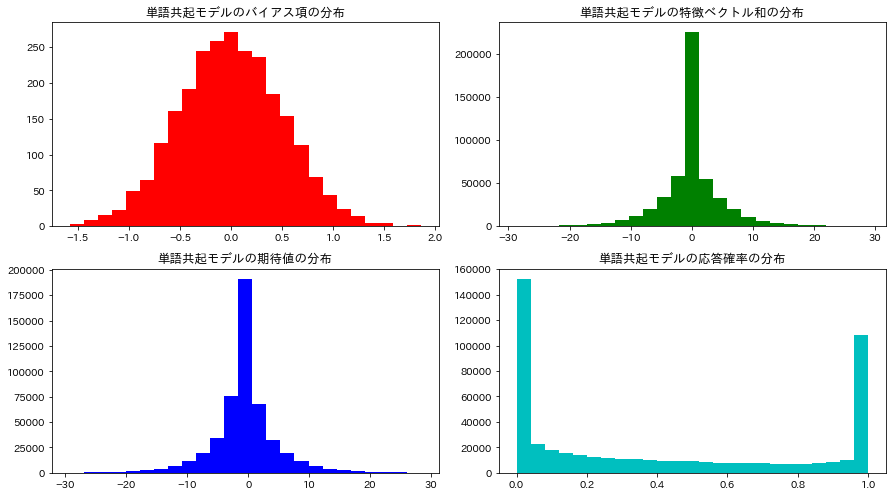

In [175]:
# 単語共起モデルの生成データを可視化
title = "単語共起モデルの"
q1 = 0.1; q2 = 99.9
dt = [beta_a, uv, mu, Prob]
fig_range = np.append(np.array([np.min(beta_a), np.percentile(uv, q1), np.percentile(mu, q1), 0]), 
                      np.array([np.max(beta_a), np.percentile(uv, q2), np.percentile(mu, q2), 1.0])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = [title + "バイアス項の分布", title + "特徴ベクトル和の分布", title + "期待値の分布",  title + "応答確率の分布"]
fig = plt.figure(figsize=(12.5, 7.0))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 2, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

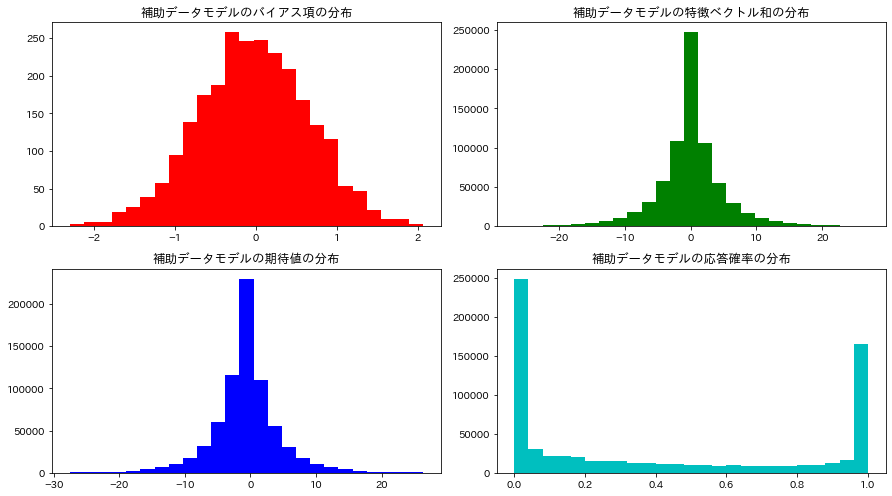

In [176]:
# 補助データモデルの生成データを可視化
title = "補助データモデルの"
q1 = 0.1; q2 = 99.9
dt = [beta_b, uv1, mu1, Prob1]
fig_range = np.append(np.array([np.min(beta_b), np.percentile(uv1, q1), np.percentile(mu1, q1), 0]), 
                      np.array([np.max(beta_b), np.percentile(uv1, q2), np.percentile(mu1, q2), 1.0])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = [title + "バイアス項の分布", title + "特徴ベクトル和の分布", title + "期待値の分布",  title + "応答確率の分布"]
fig = plt.figure(figsize=(12.5, 7.0))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 2, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

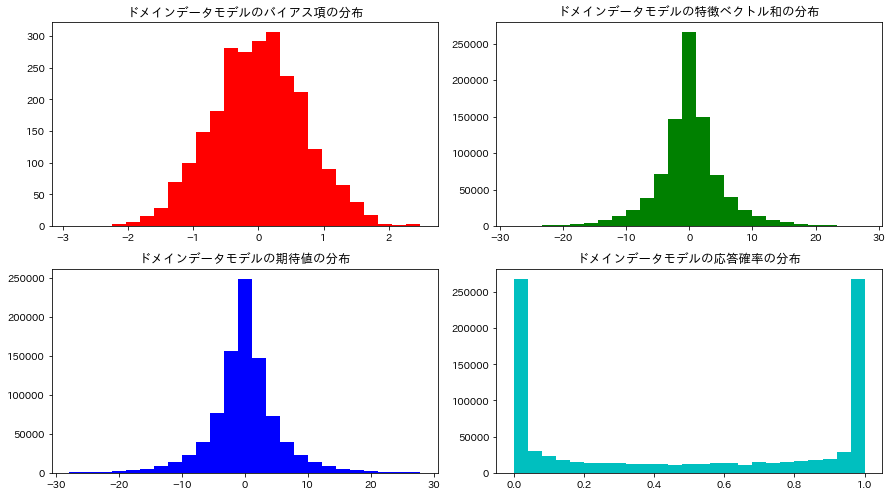

In [177]:
# ドメインデータモデルの生成データを可視化
title = "ドメインデータモデルの"
q1 = 0.1; q2 = 99.9
dt = [beta_c, uv2, mu2, Prob2]
fig_range = np.append(np.array([np.min(beta_c), np.percentile(uv2, q1), np.percentile(mu2, q1), 0]), 
                      np.array([np.max(beta_c), np.percentile(uv2, q2), np.percentile(mu2, q2), 1.0])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = [title + "バイアス項の分布", title + "特徴ベクトル和の分布", title + "期待値の分布",  title + "応答確率の分布"]
fig = plt.figure(figsize=(12.5, 7.0))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 2, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

In [178]:
# 生成したパラメータをコピーする
# バイアスパラメータをコピー
alphat_a = alpha_a.copy()
alphat_b = alpha_b.copy()
alphat_c = alpha_c.copy()
betat_a = beta_a.copy()
betat_b = beta_b.copy()
betat_c = beta_c.copy()

# モデルパラメータをコピー
thetat = theta.copy()
thetat_b = theta_b.copy()
thetat_c = theta_c.copy()
gammat = gamma.copy()
gammat_a = gamma_a.copy()
gammat_b = gamma_b.copy()
gammat_c = gamma_c.copy()
omegat_a = omega_a.copy()
omegat_b = omega_b.copy()
omegat_c = omega_c.copy()

# Semi-supervised object matching with Latent space modelを推定

In [179]:
# アルゴリズムの設定
R = 2000
keep = 2
burnin = 500
skeep = int(burnin/keep)
iters = 0
disp = 10

In [535]:
# データの定義
# 定数の定義
weights = 1.7
N = torch.Tensor([F, N1, N2])
k_vec = torch.Tensor([1.0]).repeat(k)
seg_vec = torch.Tensor([1.0]).repeat(r + max_seg)

# numpy配列をtorch配列に変換
y = torch.Tensor(y)
y1 = torch.Tensor(y1)
y2 = torch.Tensor(y2)
S1 = torch.Tensor(np.array(joint_long1!=seg+r, dtype="int"))
S2 = torch.Tensor(np.array(joint_long2!=seg+r, dtype="int"))

# パラメータインデックスを定義
index_k1 = np.arange(k1)
index_k2 = np.arange(k1, k)
index_allocation1 = np.repeat(np.arange(k), k)
index_allocation2 = np.tile(np.arange(k), k)
index_y11 = np.array(np.where(y1==1)[0], dtype="int")
index_y10 = np.array(np.where(y1==0)[0], dtype="int")
index_y21 = np.array(np.where(y2==1)[0], dtype="int")
index_y20 = np.array(np.where(y2==0)[0], dtype="int")

# データ割当のインデックス
seg_allocation1 = np.hstack((np.arange(1, k+1), np.repeat(0, k2)))
seg_allocation2 = np.hstack((np.arange(1, k1+1), np.repeat(0, k2), np.arange(k1+1, k+1)))
word_allocation = np.hstack((np.arange(k+3), np.repeat(1, 2*k2)))
word_allocation1 = np.hstack((np.arange(k1+3), np.repeat(0, k2), np.arange(k1+3, k+3), np.repeat(0, k2)))
word_allocation2 = np.hstack((np.arange(k1+3), np.repeat(0, 2*k2), np.arange(k1+3, k+3)))

# 切片を定義
zeros1 = torch.Tensor([0.0]).repeat(N1)[:, np.newaxis]
zeros2 = torch.Tensor([0.0]).repeat(N2)[:, np.newaxis]
intercept = torch.cat([torch.Tensor([1.0]).repeat(F)[:, np.newaxis], 
                       torch.Tensor([0.0]).repeat(F)[:, np.newaxis],
                       torch.Tensor([0.0]).repeat(F)[:, np.newaxis]], dim=1)
intercept1 = torch.cat([torch.Tensor([0.0]).repeat(N1)[:, np.newaxis], 
                        torch.Tensor([1.0]).repeat(N1)[:, np.newaxis],
                        torch.Tensor([0.0]).repeat(N1)[:, np.newaxis]], dim=1)
intercept2 = torch.cat([torch.Tensor([0.0]).repeat(N2)[:, np.newaxis], 
                        torch.Tensor([0.0]).repeat(N2)[:, np.newaxis],
                        torch.Tensor([1.0]).repeat(N2)[:, np.newaxis]], dim=1)

#切断領域を定義
rho = 100.0
a = (1-y)*(-rho) + y*0
b = y*rho + (1-y)*0
a1 = (1-y1)*(-rho) + y1*0
b1 = y1*rho + (1-y1)*0
a2 = (1-y2)*(-rho) + y2*0
b2 = y2*rho + (1-y2)*0

In [519]:
# 事前分布の設定
# 階層モデルの事前分布
V1 = 0.1 * torch.diag(torch.Tensor([1.0]).repeat(k1))
V2 = 0.1 * torch.diag(torch.Tensor([1.0]).repeat(k2))
nu = 1
s0 = 0.1
v0 = 0.1

# モデルパラメータの事前分布
tau = 100.0
alpha = torch.Tensor([0.0])
alpha1 = torch.Tensor([0.0]).repeat(k1+2*k2)
alpha2 = torch.Tensor([0.0]).repeat(k1+3*k2+3)
Cov = torch.Tensor(Covt.reshape(-1))

In [520]:
# パラメータの真値
# 分散共分散行列の真値
tau_a = torch.Tensor([0.5])
tau_b = torch.Tensor([0.5])
tau_c = torch.Tensor([0.5])
Cov_u = torch.diag(torch.Tensor([0.5]).repeat(k1+3*k2+3))
Cov_g = torch.diag(torch.Tensor([0.5]).repeat(k1+2*k2))
inv_Cov_u = torch.inverse(Cov_u)
inv_Cov_g = torch.inverse(Cov_g)

# バイアスパラメータの真値
pi1 = torch.Tensor(pit1)
pi2 = torch.Tensor(pit2)
alpha_a = torch.Tensor([alpha_a])
alpha_b = torch.Tensor([alpha_b])
alpha_c = torch.Tensor([alpha_c])
beta_a = torch.Tensor(beta_a)
beta_b = torch.Tensor(beta_b)
beta_c = torch.Tensor(beta_c)

# モデルパラメータの真値
Sigma = 1.0
beta_a = torch.Tensor(betat_a)
beta_b = torch.Tensor(betat_b)
beta_c = torch.Tensor(betat_c)
theta = torch.Tensor(thetat)
theta_b = torch.Tensor(thetat_b)
theta_c = torch.Tensor(thetat_c)
gamma = torch.Tensor(gammat)
gamma_a = torch.Tensor(gammat_a)
gamma_b = torch.Tensor(gammat_b)
gamma_c = torch.Tensor(gammat_c)
omega_a = torch.Tensor(omegat_a)
omega_b = torch.Tensor(omegat_b)
omega_c = torch.Tensor(omegat_c)

# パラメータを定義
beta_long1 = beta_a[wd1]; beta_long2 = beta_b[wd2]
beta_word1 = beta_b[word_id1]
beta_word2 = beta_c[word_id2]
joint_theta1 = torch.cat([theta, theta_b], dim=1)
joint_theta2 = torch.cat([theta, theta_c], dim=1)
joint_gamma1 = torch.cat([gamma, gamma_b], dim=1)
joint_gamma2 = torch.cat([gamma, gamma_c], dim=1)

In [183]:
# パラメータの格納用配列
RS = np.arange(skeep, int(R/keep))
rs = RS.shape[0]

In [131]:
# ギブスサンプリングでパラメータをサンプリング

# ベイズの定理よりsegmentをサンプリング
# パラメータの定数を定義
joint_theta1 = torch.cat([theta, theta_b], dim=1)
joint_theta2 = torch.cat([theta, theta_c], dim=1)
joint_gamma1 = torch.cat([gamma, gamma_b], dim=1)[word_id1, ]
joint_gamma2 = torch.cat([gamma, gamma_c], dim=1)[word_id2, ]
uv_deploy1 = torch.mm(joint_theta1, omega_b)
uv_deploy2 = torch.mm(joint_theta2, omega_c)

# segmentの全パターンの期待値を定義
MU1 = torch.zeros((N1, max_seg + r)); MU2 = torch.zeros((N2, max_seg + r))
UV1 = torch.zeros((N1, max_seg + r)); UV2 = torch.zeros((N2, max_seg + r))
UV1[:, :r] = torch.mm(joint_gamma1, uv_deploy1[seg:, ].T)
UV2[:, :r] = torch.mm(joint_gamma2, uv_deploy2[seg:, ].T)
MU1[:, :r] = alpha_b + beta_word1[:, np.newaxis] + UV1[:, :r]
MU2[:, :r] = alpha_c + beta_word2[:, np.newaxis] + UV2[:, :r]
for j in range(max_seg):
    index1 = seg_record1[j]
    index2 = seg_record2[j]
    UV1[index1, r+j] = torch.mv(uv_deploy1[joint_long1[index1, r+j], ] * joint_gamma1[index1] , k_vec)
    UV2[index2, r+j] = torch.mv(uv_deploy2[joint_long2[index2, r+j], ] * joint_gamma2[index2] , k_vec)
    MU1[index1, r+j] = alpha_b + beta_word1[index1] + UV1[index1, r+j]
    MU2[index2, r+j] = alpha_c + beta_word2[index2] + UV2[index2, r+j]
    
# 事後分布を定義
logit1 = torch.zeros((N1, max_seg + r)); logit2 = torch.zeros((N2, max_seg + r))
logit1[index_y10, ] = S1[index_y10] * torch.exp(-MU1[index_y10])
logit1[index_y11, ] = S1[index_y11] * torch.exp(MU1[index_y11])
logit2[index_y20, ] = S2[index_y20] * torch.exp(-MU2[index_y20])
logit2[index_y21, ] = S2[index_y21] * torch.exp(MU2[index_y21])
Posterior1 = pi1[d_id1, ] * (logit1 / torch.mv(logit1, seg_vec)[:, np.newaxis])
Posterior2 = pi2[d_id2, ] * (logit2 / torch.mv(logit2, seg_vec)[:, np.newaxis])

# 多項分布からsegmentを生成
Prob1 = Posterior1 / torch.mv(Posterior1, seg_vec)[:, np.newaxis]
Prob2 = Posterior2 / torch.mv(Posterior2, seg_vec)[:, np.newaxis]
Zi1 = torch.Tensor(rmnom(Prob1.numpy(), N1, r + max_seg, 1)[1])
Zi2 = torch.Tensor(rmnom(Prob2.numpy(), N2, r + max_seg, 1)[1])


# 新しいsegmentのidを定義
new_seg1 = np.array(torch.mv(Zi1 * torch.Tensor(joint_long1), seg_vec), dtype="int")
new_seg2 = np.array(torch.mv(Zi2 * torch.Tensor(joint_long2), seg_vec), dtype="int")

In [57]:
# 切断正規分布より潜在変数を生成
# 期待値の定義
joint_gamma = torch.cat([gamma, gamma_a], dim=1)
uv = torch.mv(torch.mm(joint_gamma, omega_a)[wd1, ] * joint_gamma[wd2, ], k_vec)
uv1 = torch.mv(Zi1 * UV1, seg_vec)
uv2 = torch.mv(Zi2 * UV2, seg_vec)
mu = alpha_a + beta_long1 + beta_long2 + uv
mu1 = torch.mv(Zi1 * MU1, seg_vec)
mu2 = torch.mv(Zi2 * MU2, seg_vec)

# 潜在変数を生成
U = rtnorm(mu, Sigma, a, b, F, 1)
U1 = rtnorm(mu1, Sigma, a1, b1, N1, 1)
U2 = rtnorm(mu2, Sigma, a2, b2, N2, 1)

In [188]:
# 期待値パラメータをサンプリング
# モデル誤差を定義
Sigma_sq = np.power(Sigma, 2)
er = U - beta_long1 - beta_long2 - uv
er1 = U1 - beta_word1 - uv1
er2 = U2 - beta_word2 - uv2
er_y = torch.Tensor([torch.sum(er), torch.sum(er1), torch.sum(er2)])

# 正規分布から期待値をサンプリング
weights = tau / (Sigma_sq / N + tau)
alpha_mu = weights * (er_y / N)
Posterior = torch.Tensor(np.random.normal(alpha_mu, weights*Sigma_sq/N, modes))
alpha_a = Posterior[0]
alpha_b = Posterior[1]
alpha_c = Posterior[2]

In [493]:
# segmentパラメータをサンプリング
# モデル誤差を定義
er1 = U1 - alpha_b - beta_word1
er2 = U2 - alpha_c - beta_word2

# 新しい入力変数を生成
joint_gamma1 = torch.cat([gamma, gamma_b], dim=1)
joint_gamma2 = torch.cat([gamma, gamma_c], dim=1)
X1 = torch.cat([zeros1, torch.mm(joint_gamma1, omega_b.T)[word_id1, ]], dim=1)[:, seg_allocation1]
X2 = torch.cat([zeros2, torch.mm(joint_gamma2, omega_c.T)[word_id2, ]], dim=1)[:, seg_allocation2]

# segmentごとに事後分布をサンプリング
for i in range(seg+r):
    
    # データを定義
    index1 = seg_list1[i][new_seg1[seg_list1[i]]==i]
    index2 = seg_list2[i][new_seg2[seg_list2[i]]==i]
    x = torch.cat([X1[index1, ], X2[index2, ]], dim=0)
    er_y = torch.cat([er1[index1], er2[index2]], dim=0)

    # 事後分布を定義
    xy = torch.mv(x.T, er_y)
    xxv = torch.mm(x.T, x) + inv_Cov_g
    inv_xxv = torch.inverse(xxv)
    theta_mu = torch.mv(inv_xxv, xy + torch.mv(inv_Cov_g, alpha1))

    # 事後分布をサンプリング
    Posterior = torch.Tensor(np.random.multivariate_normal(theta_mu, Sigma_sq*inv_xxv, 1).reshape(-1))
    theta[i, ] = Posterior[index_k1]
    theta_b[i, ] = Posterior[index_k2]
    theta_c[i, ] = Posterior[k:]

# パラメータを更新
joint_theta1 = torch.cat([theta, theta_b], dim=1)
joint_theta2 = torch.cat([theta, theta_c], dim=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: covariance is not symmetric positive-semidefinite.


In [485]:
U = torch.Tensor(Util)
U1 = torch.Tensor(Util1)
U2 = torch.Tensor(Util2)
new_seg1 = seg_id1.copy()
new_seg2 = seg_id2.copy()

In [545]:
# wordパラメータをサンプリング
# モデル誤差を定義
er11 = U - alpha_a - beta_long2
er12 = U - alpha_a - beta_long1
er1 = U1 - alpha_b
er2 = U2 - alpha_c

# 新しい入力変数を定義
X11 = torch.cat([intercept, torch.mm(joint_gamma2, omega_a.T)[wd2, ]], dim=1)[:, word_allocation]
X12 = torch.cat([intercept, torch.mm(joint_gamma1, omega_a)[wd1, ]], dim=1)[:, word_allocation]
X1 = torch.cat([intercept1, torch.mm(joint_theta1, omega_b)[new_seg1, ]], dim=1)[:, word_allocation1]
X2 = torch.cat([intercept2, torch.mm(joint_theta2, omega_c)[new_seg2, ]], dim=1)[:, word_allocation2]

# wordごとに事後分布をサンプリング
Posterior = torch.zeros((w, X11.shape[1]))
for i in range(w):
    
    # データを定義
    index11 = w_list1[i]; index12 = w_list2[i]
    index1 = word_list1[i]
    index2 = word_list2[i]
    x = torch.cat([X11[index11, ], X12[index12, ], X1[index1, ], X2[index2, ]], dim=0)
    er_y = torch.cat([er11[index11], er12[index12], er1[index1], er2[index2]], dim=0)

    # 事後分布をサンプリング
    xy = torch.mv(x.T, er_y)
    xxv = torch.mm(x.T, x) + inv_Cov_u
    inv_xxv = torch.inverse(xxv)
    gamma_mu = torch.mv(inv_xxv, xy + torch.mv(inv_Cov_u, alpha2))
    Posterior[i, ] = torch.Tensor(np.random.multivariate_normal(gamma_mu, Sigma_sq*inv_xxv, 1).reshape(-1))
    
# パラメータを出力
beta_a[i] = Posterior[:, 0]
beta_b[i] = Posterior[:, 1]
beta_c[i] = Posterior[:, 2]
gamma = Posterior[:, 3:k1+3]
gamma_a = Posterior[:, k1+3:k1+k2+3]
gamma_b = Posterior[:, k1+k2+3:k1+2*k2+3]
gamma_c = Posterior[:, k1+2*k2+3:Posterior.shape[1]]
  
# パラメータを更新
joint_gamma1 = torch.cat([gamma, gamma_b], dim=1)
joint_gamma2 = torch.cat([gamma, gamma_c], dim=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: covariance is not symmetric positive-semidefinite.


torch.Size([2500, 28])

tensor([ 0.2190, -0.0913, -0.1675,  0.0215,  0.0206, -0.0211, -0.0514, -0.2756,
        -0.2442,  0.1920])

tensor([ 0.0668, -1.6469, -0.2643,  0.8678,  0.1007])

In [546]:
Posterior[i, ]

tensor([ 0.2295, -0.2050,  1.0977,  0.2190, -0.0913, -0.1675,  0.0215,  0.0206,
        -0.0211, -0.0514, -0.2756, -0.2442,  0.1920,  0.0028,  0.1820,  0.0846,
         0.8335,  0.7928,  0.8279, -0.0109, -0.2754, -0.1718,  1.6388,  0.0668,
        -1.6469, -0.2643,  0.8678,  0.1007])

In [531]:
pd.DataFrame({"gamma": gamma_mu.numpy(), 
              "gammat": np.hstack((np.array([betat_a[i], betat_b[i], betat_c[i]]), 
                                   gammat[i, ], gammat_a[i, ], gammat_b[i, ], gammat_c[i, ]))})

,gamma,gammat
0,-0.003237,-0.266354
1,0.686169,0.583224
2,-0.807824,-0.876610
3,-0.214398,-0.163290
4,0.174219,0.123616
5,-0.253636,-0.236704
6,0.046179,-0.388423
7,-0.320039,-0.637943
8,0.223733,0.288488
9,-0.164702,-0.212362


,gamma,gammat
0,0.297619,0.569368
1,0.013852,0.042358
2,0.683538,0.650374
3,-0.166045,-0.771892
4,-0.370162,0.162217
5,0.827388,0.821038
6,-0.707668,-1.110175
7,0.342107,0.251743
8,0.030714,-0.377526
9,0.415664,0.547503


Wall time: 48.9 ms


In [ ]:
##モデルの期待値パラメータをサンプリング
#データの定義
Sigma_sq = np.power(Sigma, 2)
er_y = U - freq*beta_user - freq*beta_item - freq*uv

#正規分布から期待値をサンプリング
weights = tau / (Sigma_sq / N + tau)
mu_par = weights*np.sum(er_y)/N
beta = np.random.normal(mu_par, weights*Sigma_sq/N, 1)



In [ ]:
logit =

In [ ]:
a1


In [ ]:
np.mean((seg_id1==torch.max(torch.Tensor(joint_long1) * Zi1, axis=1)[0].numpy())[index_y11])

In [ ]:
pd.concat((pd.DataFrame({"seg": seg_id1, "y": y1}), pd.DataFrame(Prob1.numpy()), pd.DataFrame(mu1.numpy())), axis=1)

In [ ]:
np.sqrt(0.5)

In [ ]:
S1.shape

In [ ]:
Prob1.shape